In [251]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from tensorflow.keras.layers import Normalization, InputLayer, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

**Data Loading and Visualization**

In [252]:
data=pd.read_csv('AMZN.csv')
print(data.shape)
print(data.head())

(5852, 7)
         Date      Open      High       Low     Close  Adj Close    Volume
0  1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1  1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
2  1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
3  1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
4  1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200


In [253]:
data_header=data.columns
print(data_header)
#sns.pairplot(data[data_header],diag_kind="kde")

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


**Data Preparation**

In [254]:
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [255]:
'''We need to truncate Date col since it is an object type, following both way is ok'''
#tensor_data=tf.random.shuffle(tf.cast(tf.constant(data[data_header[1:]]),tf.float32)) 
tensor_data=tf.random.shuffle(tf.cast(tf.constant(data.select_dtypes(['float64','int64'])),tf.float32))
print(tensor_data.shape)
#print(tensor_data[:5])


(5852, 6)


In [256]:
'''feature data= Open High Low Volume'''
x=tf.gather(tensor_data,[0,1,2,5],axis=1)
print(x.shape)
#print(x[:5]) 

(5852, 4)


In [257]:
y=tf.gather(tensor_data,[3],axis=1)
print(y.shape)
#print(y[:5])

(5852, 1)


In [258]:
TRAIN_RATIO=.8
VAL_RATIO=.1
TEST_RATIO=.1
DATASET_SIZE=len(x)

In [259]:
x_train=x[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train=y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(x_train.shape,y_train.shape)

(4681, 4) (4681, 1)


In [260]:
x_val=x[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val=y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(x_val.shape,y_val.shape)

(585, 4) (585, 1)


In [261]:
x_test=x[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test=y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(x_test.shape,y_test.shape)

(586, 4) (586, 1)


In [262]:
normalizer=Normalization()
normalizer.adapt(x_train)
normalizer(x_train)[:5]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-0.55125415, -0.55007595, -0.55200213, -0.04429263],
       [-0.11516892, -0.12105001, -0.12093534, -0.69755596],
       [-0.4818545 , -0.4830578 , -0.4829098 , -0.20447145],
       [-0.14950791, -0.1541772 , -0.149561  , -0.7342796 ],
       [-0.57102513, -0.57088214, -0.5702308 , -0.41144344]],
      dtype=float32)>

**Model Preparation**

In [263]:
model=Sequential([
    InputLayer(shape=(x_train.shape[1],)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 4)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,802 (132.04 KB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 9 (40.00 B)

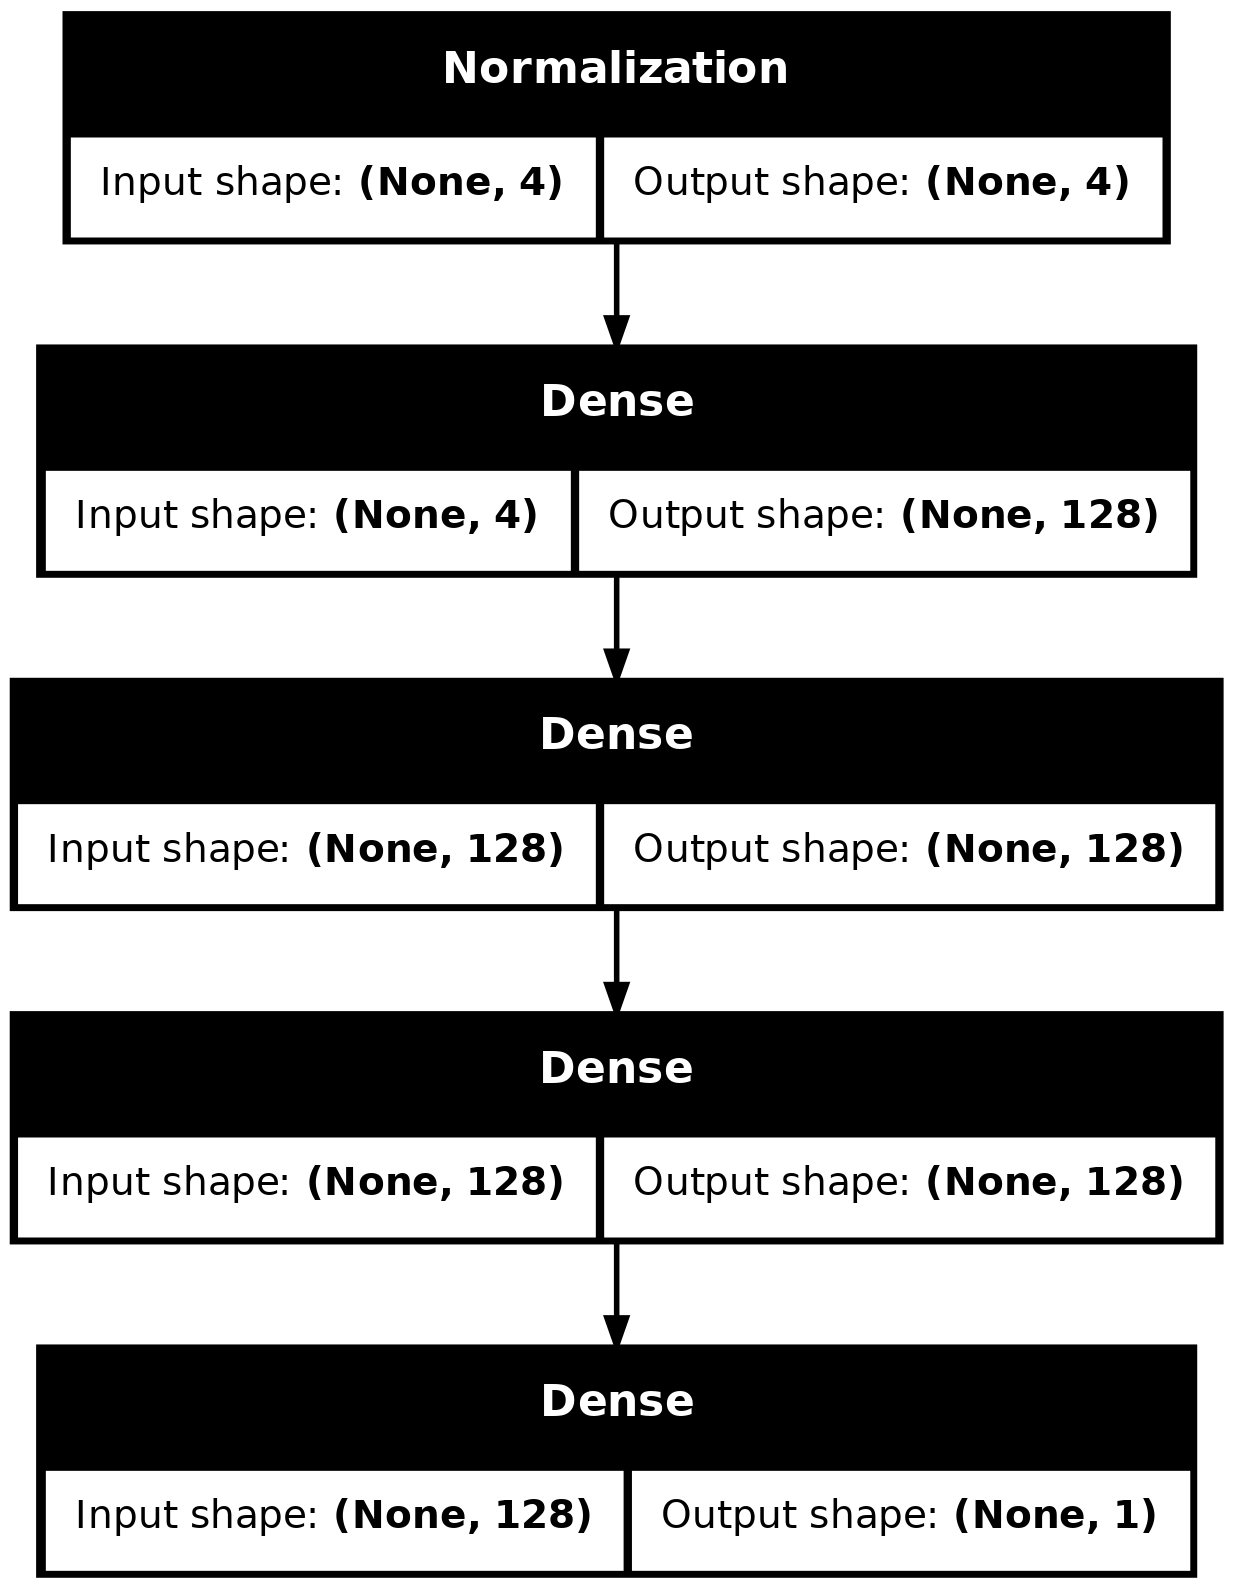

In [264]:
tf.keras.utils.plot_model(model,"model.png",True)

In [265]:
model.compile(optimizer=Adam(learning_rate=0.3), #updates model's weights and bias to reduce loss
              loss=MeanSquaredError(), #calculates loss/cost of the model
              metrics=[RootMeanSquaredError()]) # Used to evaluate and monitor how well the model is doing — but not used to train the model.

**Model Training**

In [266]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val), epochs=50,verbose=1)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 491383.5938 - root_mean_squared_error: 640.4506 - val_loss: 2073.1995 - val_root_mean_squared_error: 45.5324
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3450.2544 - root_mean_squared_error: 58.3538 - val_loss: 4998.8286 - val_root_mean_squared_error: 70.7024
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2198.5676 - root_mean_squared_error: 46.7251 - val_loss: 1009.4233 - val_root_mean_squared_error: 31.7714
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1152.4451 - root_mean_squared_error: 33.8941 - val_loss: 1907.1641 - val_root_mean_squared_error: 43.6711
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2491.6128 - root_mean_squared_error: 48.2706 - val_loss: 3090.7183 - val_root_mean_squared_error: 55.5942
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1209.9146 - root_mean_squared_error: 34.4477 - val_loss: 495.8635 - val_root_mean_squared_error: 22.2680
Ep

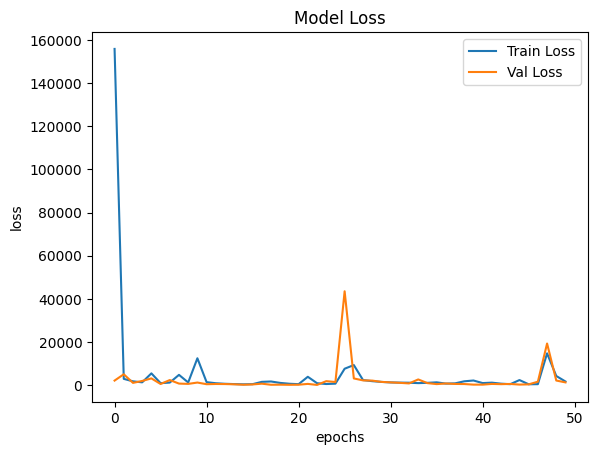

In [267]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train Loss","Val Loss"])
plt.show()


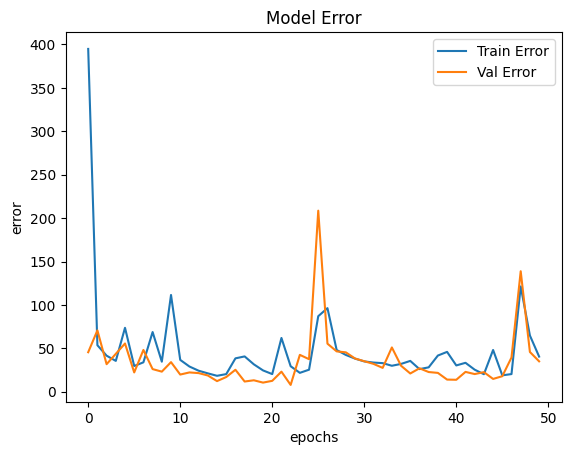

In [268]:
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_root_mean_squared_error"])
plt.title("Model Error")
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend(["Train Error","Val Error"])
plt.show()

**Performance**

In [269]:
model.evaluate(x_test,y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1187.0342 - root_mean_squared_error: 34.4220 


[1093.70849609375, 33.07126235961914]

In [270]:
y_true=list(y_test[:,0].numpy())
print(y_true)
y_pred=list(model.predict(x_test)[:,0])
print(y_pred)

[np.float32(83.42), np.float32(258.48), np.float32(176.27), np.float32(130.46), np.float32(79.59375), np.float32(384.66), np.float32(295.74), np.float32(38.81), np.float32(48.06), np.float32(359.0), np.float32(48.71875), np.float32(129.65), np.float32(85.32), np.float32(1949.72), np.float32(33.0), np.float32(2.322917), np.float32(1715.67), np.float32(259.06), np.float32(1.65625), np.float32(1796.62), np.float32(42.32), np.float32(232.06), np.float32(643.3), np.float32(1189.01), np.float32(35.74), np.float32(385.37), np.float32(134.03), np.float32(75.46875), np.float32(43.72), np.float32(39.52), np.float32(13.26), np.float32(60.65625), np.float32(2680.38), np.float32(38.51), np.float32(44.45), np.float32(360.13), np.float32(42.375), np.float32(53.0625), np.float32(53.93), np.float32(5.40625), np.float32(72.81), np.float32(2.317708), np.float32(118.49), np.float32(1760.69), np.float32(1834.33), np.float32(263.55), np.float32(24.75), np.float32(174.85), np.float32(4.645833), np.float32(42

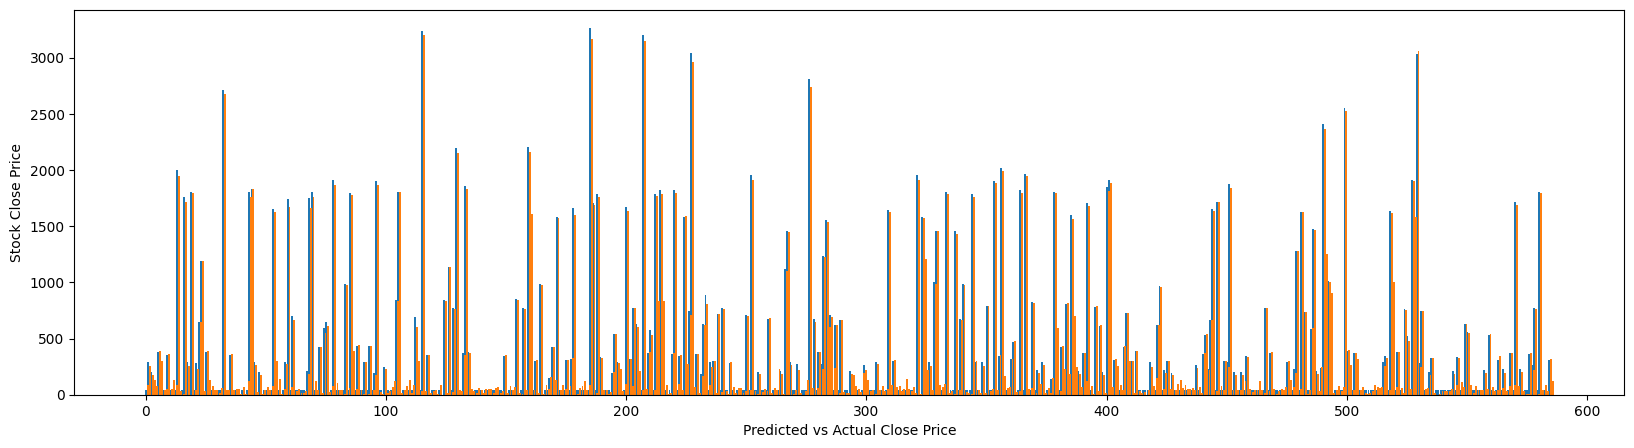

In [271]:
ind=np.arange(586)
plt.figure(figsize=(20,5))

width=0.8

plt.bar(ind, y_pred, width, label="Predicted Close Price")
plt.bar(ind+width, y_true, width, label="Predicted Close Price")

plt.xlabel("Predicted vs Actual Close Price")
plt.ylabel("Stock Close Price")

plt.show()